In [ ]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum optimization for job-shop scheduling problems

This notebook describes the application of the Gauss-Newton quantum algorithm (GNQA) to job-shop scheduling problems.<sup>1</sup>

#### Import packages

In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
import numpy as np 
from itertools import product
import matplotlib.pyplot as plt
from src.ADMM_MIP import ADMMxGNQA_Optimizer, ADMMxClassical_Optimizer

### Problem statement

The job-shop scheduling problem (JSP) is formulated by a finite set $\mathcal{J} = \{ 1, \ldots, n \}$ of $n$ jobs and a finite set $\mathcal{M} = \{ 1, \ldots, m \}$ of $m$ machines, referred to as an $n \times m$ problem. 

For each job $j \in \mathcal{J}$, we are given a list $( o^j_1, \ldots, o^j_h, \ldots, o^j_m )$ of the machines, expressing the processing order of $j$ through the machines. 
Here, $o^j_h$ is the $h$-th operation of job $j$, and $o^j_m$ is the last operation of job $j$. 
In addition, for each job $j$ and machine $i$, we are given a non-negative integer $p_{ij}$ representing the processing time of job $j$ on machine $i$. 
Each machine can process at most one job at a time, and once a job starts on a given machine, it must finish processing on that machine without interruption. 
The objective is to find a schedule of $\mathcal{J}$ on $\mathcal{M}$ that minimizes the makespan—namely, the maximum completion time of the last operation of any job in $\mathcal{J}$. 
The JSP is known to be NP-hard for $n \geq 3$ and $m \geq 3$. This notebook addresses a $3 \times 3$ problem.

### Toy example

In this notebook, we deal with a small case of the JSP to demonstrate the quantum algorithm.
Specifically, we use the data of three machines and three jobs:
- $\mathcal{J} = \{ 1,2,3 \}$
- $\mathcal{M} = \{ 1,2,3 \}$

The data sets of processing order and time are given as follows:

- table for processing order $o^j_i$

|                   |  Job 1 |  Job 2 |  Job 3 |
|-------------------|  :--:  |  :--:  |  :--:  |
|  **operation 1**  |    3   |    2   |    3   |
|  **operation 2**  |    1   |    3   |    2   |
|  **operation 3**  |    2   |    1   |    1   |

- table for processing time $p_{ij}$

|                 |  job 1 |  job 2 |  job 3 |
|-----------------|  :--:  |  :--:  |  :--:  |
|  **machine 1**  |    2   |    1   |    1   |
|  **machine 2**  |    1   |    2   |    2   |
|  **machine 3**  |    2   |    2   |    1   |

In [2]:
num_J = 3
num_M = 3

d_order = np.array([
    [2, 1, 2],
    [0, 2, 1],
    [1, 0, 0]
    ]).astype(int)

d_time = np.array([
    [2, 1, 1],
    [1, 2, 2],
    [2, 2, 1]
    ])

### Basic formulation

To model the JSP mathematically, we use the decision variables defined by:
- $x_{ijk}$ : binary variable that is equal to $1$ if job $j \in \mathcal{J}$ precedes job $k \in \mathcal{J}$ on machine $i \in \mathcal{M}$ and otherwise 0
- $y_{ij}$ : continuous variable that represents a starting time of job $j \in \mathcal{J}$ on machine $i \in \mathcal{M}$
- $C$ : continuous variable for the makespan

Our model follows a standard MIP formulation<sup>2</sup> for the JSP:

\begin{align*}
    & \text{minimize} && C\\
    & \text{subject to} && y_{o^j_h j} \ge y_{o^j_{h-1} j} + p_{o^j_{h-1} j} &&& \forall j \in \mathcal{J}, h = 2,\ldots,m \\
    & && y_{ij} \ge y_{ik} + p_{ik} - V \cdot x_{ijk} &&& \forall j,k \in \mathcal{J}, j < k, i \in \mathcal{M} \\
    & && y_{ik} \ge y_{ij} + p_{ij} - V \cdot (1 - x_{ijk}) &&& \forall j,k \in \mathcal{J}, j < k, i \in \mathcal{M} \\
    & && C \ge y_{o^j_mj} + p_{o^j_mj} &&& \forall j \in \mathcal{J} \\
    & && y_{ij} \ge 0 &&& \forall j \in \mathcal{J}, i \in \mathcal{M} \\
    & && x_{ijk} \in \{0, 1\} &&& \forall j,k \in \mathcal{J}, i \in \mathcal{M}
\end{align*}
where $V$ is a sufficiently large number, for example, $\text{max}_{i}  \{ \sum_{j} p_{ij} \}.$

**Some points to note:**

- For our implementation, it is crucial to define all binary variables first and then all continuous variables.
- With respect to the notation for constraints, **`EQ`**, **`LE`**, and **`GE`** mean $=$, $\le$, and $\ge$, respectively.

In [3]:
mdl = QuadraticProgram('JSP')

# binary variables
for i,j,k in product(range(num_M), range(num_J), range(num_J)):
    if j>=k: continue
    mdl.binary_var(name=f'x({i},{j},{k})')

# maximum makespan
C_max = sum(d_time[i,j] for i,j in product(range(num_M), range(num_J)))

# continuous variables
mdl.continuous_var(lowerbound=0, name='C')
for i,j in product(range(num_M), range(num_J)):
    mdl.continuous_var(lowerbound=0, name=f'y({i},{j})')

# objective function
mdl.minimize(linear = {'C':1})

# ge constraints 1
for i,j in product(range(1, num_M), range(num_J)):
    mdl.linear_constraint(
        linear = {f'y({d_order[i-1,j]},{j})':-1, f'y({d_order[i,j]},{j})':1}, 
        sense = '>=', 
        rhs = d_time[d_order[i-1,j], j]
        )
    
# ge constraints 2
for i,j,k in product(range(num_M), range(num_J), range(num_J)):
    if j>=k: continue
    mdl.linear_constraint(
        linear = {f'y({i},{j})':1, f'y({i},{k})':-1, f'x({i},{j},{k})':C_max}, 
        sense = '>=', 
        rhs = d_time[i,k]
        )
    mdl.linear_constraint(
        linear = {f'y({i},{j})':-1, f'y({i},{k})':1, f'x({i},{j},{k})':-C_max}, 
        sense = '>=', 
        rhs = -C_max + d_time[i,j]
        )

# ge constraints 3
for j in range(num_J):
    mdl.linear_constraint(
        linear = {'C':1, f'y({d_order[-1,j]},{j})':-1}, 
        sense = '>=', 
        rhs = d_time[d_order[-1,j], j]
        )

### Implementation

#### Solve the problem with quantum solvers

For solving the JSP, we demonstrate the quantum algorithm by using the module `ADMMxGNQA_Optimizer`, which is constructed based on Qiskit and our original quantum algorithm, GNQA.<sup>2</sup> The alternating direction method of multipliers (ADMM) is a classical algorithm that works well in problems with both binary and continuous variables, such as the problem explored in this notebook. It is an iterative algorithm that solves the problem on binary variables with the continuous variables fixed, and vice versa—the problem on continuous variables with the binary variables fixed. For more details about the classical algorithm, refer to Boyd et al. 2011.<sup>3</sup> 

Because the problem in binary variables is hard and classical solvers don’t perform well with large instances, quantum algorithms provide hope of solving these binary optimization problems more efficiently. For this reason, we can use a quantum algorithm to solve the binary variable problem while we use the classical solvers such as CPLEX for the continuous variable problem. There are several quantum algorithms that can be used in such an approach, including QAOA and VQE.<sup>4,5</sup> In `ADMMxGNQA_Optimizer`, we use the quantum algorithm GNQA to solve the binary optimization problem and CPLEX to solve the continuous variable problem.

In [4]:
ADMMxQuantum = ADMMxGNQA_Optimizer(mdl)

#### Check the status of the problem

It is possible to check the status of the problem from the MIP model set up above using the module `ADMMxGNQA_Optimizer`.
In what follows, we display the number of binary variables, the number of continuous variables, and the number of constraints.

In [5]:
n_bin_vars = ADMMxQuantum.n_bin_vars
n_cont_vars = ADMMxQuantum.n_cont_vars
n_eq = ADMMxQuantum.n_eq
n_le = ADMMxQuantum.n_le
n_ge = ADMMxQuantum.n_ge

print(
        '-'*50,
        '[Problem Information]',
        '- Decision Variables',
        f'   number of binary vars: {n_bin_vars}',
        f'   number of continuous vars: {n_cont_vars}',
        '- Linear Constraints',
        f'   number of eq constraints: {n_eq}',
        f'   number of le constraints: {n_le}',
        f'   number of ge constraints: {n_ge}',
        '-'*50,
        sep='\n'
    )

--------------------------------------------------
[Problem Information]
- Decision Variables
   number of binary vars: 9
   number of continuous vars: 10
- Linear Constraints
   number of eq constraints: 0
   number of le constraints: 0
   number of ge constraints: 27
--------------------------------------------------


We now solve the problem using IBM’s original method.

#### Reformulate

Introducing slack variables $s_i \geq 0$, we convert the MIP model into the following formulation that our algorithm solves:

\begin{align*}
    & \underset{q,u} {\text{minimize}} && c_{\mathrm{bin}} \, q + c_{\mathrm{pos}} \, u \\
    & \text{subject to} && a_{\mathrm{bin}} \, q + a_{\mathrm{pos}} \, u = b,
\end{align*}

where $q$ denotes a binary vector and $u$ denotes a non-negative real valued vector.

In our case, $q$ consists of binary decision variables $x_{ijk}$ and $u$ consists of continuous decision variables $C$, $y_{ij}$ and slack variables $s_i$.

#### Use an augmented Lagrangian

Then we solve the minimization problem of the following Lagrangian:

\begin{equation*}
  L \left( q, u, \lambda \right) 
  = c_{\mathrm{bin}} \, q + c_{\mathrm{pos}} \, u
    + \lambda \cdot \left( b - a_{\mathrm{bin}} \, q - a_{\mathrm{pos}} \, u \right) 
    + \frac{\rho}{2} \left\| b - a_{\mathrm{bin}} \, q - a_{\mathrm{pos}} \, u \right\|_2^2
\end{equation*}

#### Specify the initial condition

Next, let us specify the initial state of the optimization process.
It is recommended to set the relaxation solution to the initial state as in the classical approach.
Here, the relaxation solution refers to the solution of the target MIP with all decision variables continuous.
To select a better initial state, you may want to extract the relaxation solution with additional constraints obtained from cutting-plane techniques, such as the Gomory cut, which is even more efficient.

In [6]:
sol_relax = np.array([
    0.976190476190476, 1.,                0.076530612244898, 0.,
    0.,                1.,                0.994897959183674, 0.928571428571429,
    0.005102040816327, 5.071428571428571, 2.071428571428571, 4.,
    4.071428571428571, 4.071428571428571, 0.,                2.071428571428571,
    0.071428571428571, 2.,                1.071428571428571,
    ])

In [7]:
step_max = 5
n_lin_const = ADMMxQuantum.n_lin_const
x_ini = sol_relax.copy()
lam_ini = np.full(n_lin_const, 1.)
rho = 1.

p = 8
filter_function = lambda x: np.exp(-(p*x)**2)
gnqa_step_max = 5
Omega = [0,1] 
epsiron = 1e-1

admm_result = ADMMxQuantum.solve(step_max, x_ini, lam_ini, rho, gnqa_step_max, filter_function, Omega, epsiron)
x_sol = admm_result.x
n_bin = mdl.get_num_binary_vars()

np.set_printoptions(formatter={'float': '{:.3f}'.format})
print(
        '-'*100,
        '[ADMMxGNQA Result]',
        f'   optimal value: {admm_result.fval:.3f}',
        f'   optimal solution (binary): {x_sol[:n_bin].astype(int)}',
        f'   optimal solution (continuous): {x_sol[n_bin:]}',
        f'   status: {admm_result.status.name}',
        '-'*100,
        sep='\n'
    )

----------------------------------------------------------------------------------------------------
[ADMMxGNQA Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 0 0 0 1 1 1 0]
   optimal solution (continuous): [7.000 2.373 6.000 5.000 5.778 0.216 3.000 0.000 3.662 2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------


### Compare with the classical solver

Let us compare the result above with the solution generated by the classical solver.
Here we check the results of the solution using CPLEX, an IBM product.
We can see that for these two methods, the values of the optimized objective function are consistent.
The decision variables indicating the start time have degrees of freedom to the extent that the constraints are satisfied.
Note, therefore, that decision variables obtained by two different methods do not necessarily coincide.
What matters is the value of the objective function and whether the resulting solution is feasible.

In [8]:
cplex_result = CplexOptimizer().solve(mdl)
opt_val = cplex_result.fval
x_sol = cplex_result.x

n_bin = mdl.get_num_binary_vars()

np.set_printoptions(formatter={'float': '{:.3f}'.format})
print(
        '-'*100,
        '[CPLEX Result]',
        f'   optimal value: {cplex_result.fval:.3f}',
        f'   optimal solution (binary): {x_sol[:n_bin].astype(int)}',
        f'   optimal solution (continuous): {x_sol[n_bin:]}',
        f'   status: {cplex_result.status.name}',
        '-'*100,
        sep='\n'
    )

----------------------------------------------------------------------------------------------------
[CPLEX Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 0 0 0 1 1 1 0]
   optimal solution (continuous): [7.000 3.000 6.000 5.000 6.000 0.000 3.000 0.000 3.000 2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------


### Visualize the optimization process

Let us visualize the result of the optimization process using `ADMMxQuantum.draw`.
Our method recorded the optimization steps, which we can see by calling `ADMMxQuantum.opt_record`.

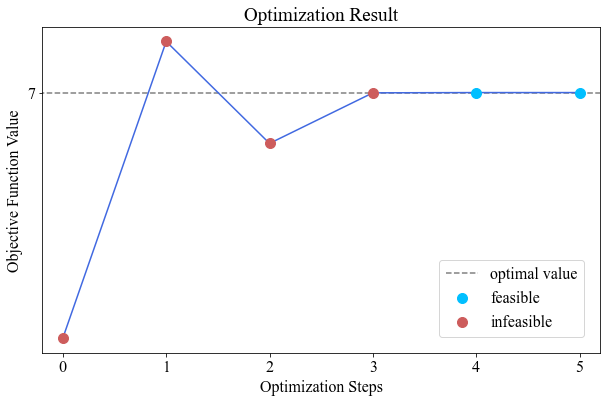

In [9]:
ADMMxQuantum.draw(exact_val=cplex_result.fval, fig_size=[10,6], font_size=16)

### Visualize the results

Additionally, we can visualize the result in the schedule chart.

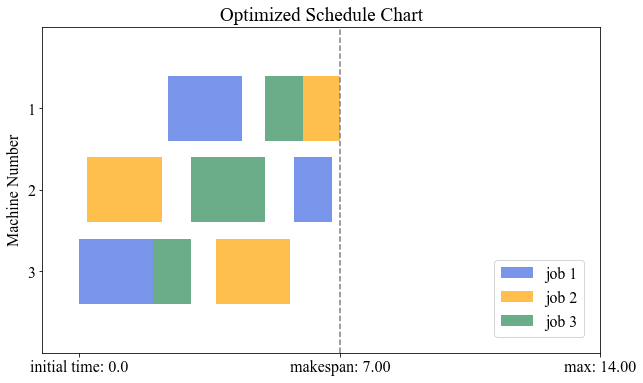

In [10]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["figure.figsize"] = [10, 6]

# Declaring a figure "gnt"
fig, gnt = plt.subplots()
 
# Setting Y-axis limits
gnt.set_ylim(0, num_M+1)
 
# Setting X-axis limits
gnt.set_xlim(-1, C_max)
 
# Setting labels for x-axis and y-axis
gnt.set_ylabel('Machine Number')
 
# Setting ticks on y-axis
gnt.set_yticks([k for k in range(1,num_M+1)])
gnt.set_yticklabels(['3', '2', '1'])

c_val = admm_result.variables_dict['C']
gnt.set_xticks(
    [0, c_val, C_max],
    [f'initial time: {0.}', f'makespan: {c_val:.2f}', f'max: {C_max:.2f}']
    )

ofs = 0.4
f_color_list = ['royalblue', 'orange', 'seagreen']
label_list = [
    ['job 1', 'job 2', 'job 3'],
    ['', '', ''],
    ['', '', ''],
]
x_dict = admm_result.variables_dict
for i,j in product(range(num_M), range(num_J)):
    gnt.broken_barh(
        [(x_dict[f'y({i},{j})'], d_time[i,j])], (num_M-i-ofs, 2*ofs), 
        facecolors =(f_color_list[j]), alpha = 0.7,
        label = label_list[i][j]
        )

gnt.vlines(x=c_val, ymin=0, ymax=num_M+1, linestyle='dashed', color='gray', linewidth=1.5)

plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize='medium')
plt.title('Optimized Schedule Chart')

plt.show()

### References

1. <a name="ref1"></a>Mitsuharu Takeori et al. “A Gauss-Newton Based Quantum Algorithm for Combinatorial Optimization.” arXiv:2203.13939, 2022. [https://arxiv.org/pdf/2203.13939.pdf](https://arxiv.org/pdf/2203.13939.pdf).

2. <a name="ref2"></a>Alan S. Manne. “On the Job-Shop Scheduling Problem.” *Operations Research*, vol. 8, no. 2 (1960): 219–223, [https://doi.org/10.1287/opre.8.2.219](https://doi.org/10.1287/opre.8.2.219).

3. <a name="ref3"></a>Stephen Boyd et al. *Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers*. Foundations and Trends in Machine Learning, 2011. [https://www.nowpublishers.com/article/Details/MAL-016](https://www.nowpublishers.com/article/Details/MAL-016).

4. <a name="ref4"></a> <a id='QiskitPauli'></a>“Qiskit Solving Combinatorial Optimization Problems Using QAOA.” *Qiskit*. [https://qiskit.org/textbook/ch-applications/qaoa.html](https://qiskit.org/textbook/ch-applications/qaoa.html).

5. <a name="ref5"></a><a id='QiskitPauli'></a>“Qiskit Simulating Molecules Using VQE.” *Qiskit*. [https://qiskit.org/textbook/ch-applications/vqe-molecules.html](https://qiskit.org/textbook/ch-applications/vqe-molecules.html).

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>